# Bias-hardened estimator for asymmetric estimator

In [1]:
# external
import numpy as np, sys
from matplotlib.pyplot import *

In [2]:
# add path to tempura
path_to_tempura = "/global/homes/t/toshiyan/Work/Lib/tempura_dev/" # please change this path
sys.path.append(path_to_tempura) # example
import pytempura as cs

First define parameters

In [3]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 3000       # maximum multipole of output normalization
lmax  = 3000
rlmin, rlmax = 2, 3000  # CMB multipole range for reconstruction
glmin, glmax = 2, 3000
llmin, llmax = 2, 3000
L = np.linspace(0,Lmax,Lmax+1)
l = L.copy()
Lfac = (L*(L+1.))**2/2./np.pi

Load arrays of lensed CMB Cls. The Cls should not be multiplied by any factors and should not have units.  

In [4]:
lcl = np.zeros((4,lmax+1)) # TT, EE, BB, TE
lcl[:,2:] = np.loadtxt('data/lensedcls.dat',unpack=True,usecols=(1,2,3,4))[:,:lmax-1] 
lcl *= 2.*np.pi / (l**2+l+1e-30) / Tcmb**2
ucl = np.zeros((5,lmax+1)) # TT, EE, TE, pp, Tp
ucl[:,2:] = np.loadtxt('data/unlensedcls.dat',unpack=True,usecols=(1,2,3,4,5))[:,:lmax-1] 

Define observed CMB cls. Here, two CMB noise (high and low resolution).

In [5]:
ac2rad = np.pi/10800.
sigmaG = 40.
sigmaL = 20.
thetaG = 7.
thetaL = 1.5
nlG = (sigmaG*ac2rad/Tcmb)**2 * np.exp(L*(L+1.)*(thetaG*ac2rad)**2/8./np.log(2.))
nlL = (sigmaL*ac2rad/Tcmb)**2 * np.exp(L*(L+1.)*(thetaL*ac2rad)**2/8./np.log(2.))
nlL *= (1+(L/3000.)**(-4.))
nlL[:500] = 1e30

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


In [6]:
oclG = lcl[0] + nlG # observed Cl
oclL = lcl[0] + nlL

### Compute normalization and Response

In [7]:
Akk = cs.norm_general.qtt_asym('lens',Lmax,glmin,glmax,llmin,llmax,llmax,lcl[0,:],oclG,oclL)[0]
Ass = cs.norm_general.qtt_asym('src',Lmax,glmin,glmax,llmin,llmax,llmax,lcl[0,:],oclG,oclL)[0]

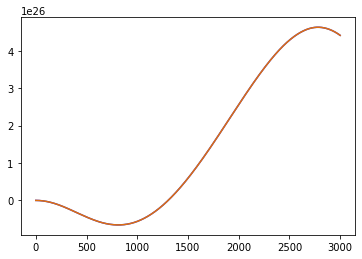

In [8]:
# check
Rsym  = cs.norm_general.xtt('lenssrc',Lmax,llmin,llmax,lcl[0,:],oclG)
Rasym = cs.norm_general.xtt_asym('lenssrc',Lmax,glmin,glmax,llmin,llmax,llmax,lcl[0,:],oclG,oclG)
plot(Rsym)
plot(Rasym)

In [9]:
# response of the asymmetric lensing estimator to source
Rks = Akk*cs.norm_general.xtt_asym('lenssrc',Lmax,glmin,glmax,llmin,llmax,llmax,lcl[0,:],oclG,oclL)[0]
# response of the asymmetric source estimator to lensing
Rsk = Ass*cs.norm_general.xtt_asym('srclens',Lmax,glmin,glmax,llmin,llmax,llmax,lcl[0,:],oclG,oclL)[0]

### Compute noise spectrum

In [10]:
a0a1 = oclL.copy()
b0b1 = oclG.copy()
a0b1 = lcl[0]
a1b0 = lcl[0]

In [11]:
wx0  = 1./oclL
wx1  = wx0.copy()
wxy0 = np.zeros(rlmax+1)
wxy0[rlmin:] = lcl[0][rlmin:]/oclG[rlmin:]
wxy1 = wxy0.copy()

In [12]:
Nkk = Akk**2*cs.noise_spec.qtt_asym('lens',Lmax,rlmin,rlmax,wx0,wxy0,wx1,wxy1,a0a1,b0b1,a0b1,a1b0)[0]

In [13]:
Wxy0 = wxy0/(2.*lcl[0])**2
Wxy1 = wxy1/(2.*lcl[0])**2

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [14]:
Nss = Ass**2*cs.noise_spec.qtt_asym('src',Lmax,rlmin,rlmax,wx0,Wxy0,wx1,Wxy1,a0a1,b0b1,a0b1,a1b0)[0]

In [15]:
Nks = Akk*Ass*cs.noise_spec.xtt_asym('lenssrc',Lmax,rlmin,rlmax,wx0,wxy0,wx1,Wxy1,a0a1,b0b1,a0b1,a1b0)

In [16]:
Nsk = Akk*Ass*cs.noise_spec.xtt_asym('srclens',Lmax,rlmin,rlmax,wx0,Wxy0,wx1,wxy1,a0a1,b0b1,a0b1,a1b0)

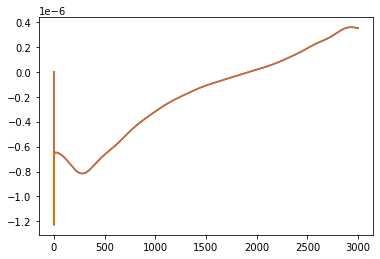

In [17]:
# the following two has to be equal
plot(L,np.sqrt(Lfac)*Nks,label='lens x src')
plot(L,np.sqrt(Lfac)*Nsk,label='src x lens')

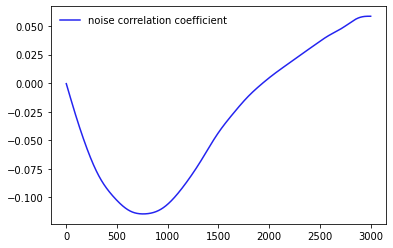

In [18]:
plot(L[1:],Nks[1:]/np.sqrt(Nkk[1:]*Nss[1:]),label='noise correlation coefficient')
legend()

In [19]:
# noise covariance
Ncov = np.zeros((Lmax+1,2,2))
Ncov[:,0,0] = Nkk
Ncov[:,0,1] = Nks
Ncov[:,1,0] = Nsk
Ncov[:,1,1] = Nss

In [20]:
# Response matrix
Rmat = np.ones((Lmax+1,2,2))
Rmat[:,0,1] = Rks
Rmat[:,1,0] = Rsk
IRmat = np.array([ np.linalg.inv(Rmat[Li,:,:]) for Li in range(Lmax+1) ])

In [21]:
Nl_BH = np.array( [ np.dot(np.dot(IRmat[Li,:,:],Ncov[Li,:,:]),IRmat[Li,:,:].T) for Li in range(Lmax+1) ] )

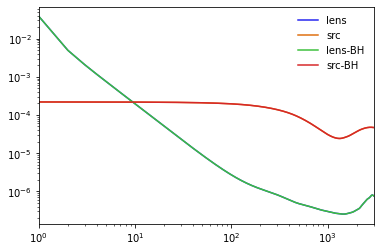

In [22]:
xlim(1,Lmax)
loglog(L,Lfac*Nkk,label='lens')
loglog(L,Nss,label='src')
loglog(L,Lfac*Nl_BH[:,0,0],label='lens-BH')
loglog(L,Nl_BH[:,1,1],label='src-BH')
legend()

In [23]:
Nkk_BH = (Nkk-2*Rks*Nks+Rks**2*Nss)/(1-Rsk*Rks)

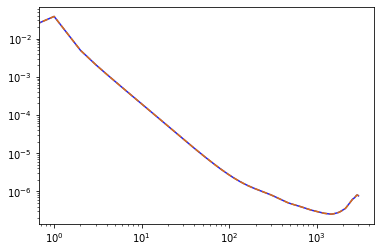

In [24]:
loglog(L,Lfac*Nl_BH[:,0,0],label='lens-BH')
loglog(L,Lfac*Nkk_BH,label='lens-BH',ls='--')